In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import glob
import os
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev

warnings.filterwarnings('ignore')

In [69]:
otm_fp = '/home/mremington/Documents/therma_sim/ibutton_data_analysis/OTM_Main_Database.csv'
otm_data = pd.read_csv(otm_fp, index_col=0)
otm_data['Date'] = pd.to_datetime(otm_data['Date'])
otm_data = otm_data.drop(columns=['Lat', 'Long'])
microhabitat = []
for index, row in otm_data.iterrows():
    if row['OTM_ID']=='Air Temperature':
        micro = 'Air_Temperature'
    else:
        micro = row['Microhabitat']
    microhabitat.append(micro)
otm_data['Microhabitat'] = microhabitat
otm_data = otm_data.dropna(subset=['Microhabitat']).sort_values(by=['Study_Site', 'Date'], ascending=True)
otm_data.head()



,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,OTM_ID,file_name,Microhabitat,season
0,2022-06-17 23:00:01,C,17.663,2022,6,17,23,0,Canada,OTM8,OTM8_burrow_CAN_2022.csv,Burrow,Spring
7152,2022-06-17 23:00:01,C,16.610,2022,6,17,23,0,Canada,OTM9,OTM9_burrow_CAN_2022.csv,Burrow,Spring
14304,2022-06-17 23:00:01,C,22.580,2022,6,17,23,0,Canada,Air Temperature,Air_Temp_CAN_2022.csv,Air_Temperature,Spring
21456,2022-06-17 23:00:01,C,21.119,2022,6,17,23,0,Canada,OTM1,OTM1_open_CAN_2022.csv,Open,Spring
28608,2022-06-17 23:00:01,C,21.125,2022,6,17,23,0,Canada,OTM4,OTM4_open_CAN_2022.csv,Open,Spring


In [20]:
nan_microhabitat_rows = otm_data[otm_data['Microhabitat'].isna()]
nan_microhabitat_rows.head()#['file_name'].unique()

,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,OTM_ID,file_name,Microhabitat,season
42912,2022-06-17 23:00:01,C,20.121,2022,6,17,23,0,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring
42913,2022-06-18 00:10:01,C,19.120,2022,6,18,0,10,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring
42914,2022-06-18 01:20:01,C,19.120,2022,6,18,1,20,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring
42915,2022-06-18 02:30:01,C,17.617,2022,6,18,2,30,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring
42916,2022-06-18 03:40:01,C,17.116,2022,6,18,3,40,Canada,OTM13,OTM13_halfburrow_CAN_2022.csv,NaN,Spring


In [71]:
spark = SparkSession.builder.appName("PandasToSparkPivot").getOrCreate()
spark_df = spark.createDataFrame(otm_data)

# Pivot the Spark DataFrame
otm_data = spark_df.groupBy('year', 'month',
                          'day','hour', 'Study_Site').pivot("Microhabitat").agg(
    mean("Temperature").alias("mean_Temperature"),
    stddev("Temperature").alias("stddev_Temperature")
)


# Display the pivoted Spark DataFrame
otm_data = otm_data.toPandas()
otm_data = otm_data.sort_values(by=['Study_Site', 'year', 'month', 'day', 'hour'], ascending=True).reset_index(drop=True)
otm_data['DateTime'] = pd.to_datetime(otm_data[['year', 'month', 'day', 'hour']])
otm_data.drop(columns=['Air_Temperature_mean_Temperature', 'Air_Temperature_stddev_Temperature'], inplace=True)
columns_to_check = ['Burrow_mean_Temperature', 'Open_mean_Temperature', 'Shrub_mean_Temperature']
otm_data = otm_data.dropna(subset=columns_to_check)
# Calculate the mean of standard deviation grouped by DateTime ignoring the Study_Site
mean_stddev_by_date = otm_data.groupby(otm_data['DateTime'])['Burrow_stddev_Temperature'].mean().reset_index()
mean_stddev_by_date.columns = ['DateTime', 'Mean_StdDev']


# # Merge the mean stddev back to the original dataframe
# otm_data['Date'] = otm_data['DateTime'].dt.date
otm_data = pd.merge(otm_data, mean_stddev_by_date, on='DateTime', how='left')
# # Replace the standard deviation for the Nebraska study site
otm_data.loc[otm_data['Study_Site'] == 'Nebraska', 'Burrow_stddev_Temperature'] = otm_data['Mean_StdDev']

# # Drop the helper columns
#otm_data.drop(columns=['Date', 'Mean_StdDev','Mean_StdDev_x','Mean_StdDev_y'], inplace=True)

otm_data.head()

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime,Mean_StdDev
0,2022,6,17,23,Canada,18.48650,1.632718,21.1220,0.004243,21.633000,0.493000,2022-06-17 23:00:00,1.632718
1,2022,6,18,0,Canada,17.86075,1.034088,18.3690,0.359210,18.963333,1.035800,2022-06-18 00:00:00,1.062093
2,2022,6,18,1,Canada,17.73575,1.094420,19.1205,0.004950,19.965000,0.570721,2022-06-18 01:00:00,1.052493
3,2022,6,18,2,Canada,16.85950,0.661747,16.3660,0.359210,17.628000,0.859970,2022-06-18 02:00:00,0.904428
4,2022,6,18,3,Canada,16.48375,0.499659,15.3645,0.359917,16.458667,0.571007,2022-06-18 03:00:00,0.874555


In [72]:

otm_data.head()

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime,Mean_StdDev
0,2022,6,17,23,Canada,18.48650,1.632718,21.1220,0.004243,21.633000,0.493000,2022-06-17 23:00:00,1.632718
1,2022,6,18,0,Canada,17.86075,1.034088,18.3690,0.359210,18.963333,1.035800,2022-06-18 00:00:00,1.062093
2,2022,6,18,1,Canada,17.73575,1.094420,19.1205,0.004950,19.965000,0.570721,2022-06-18 01:00:00,1.052493
3,2022,6,18,2,Canada,16.85950,0.661747,16.3660,0.359210,17.628000,0.859970,2022-06-18 02:00:00,0.904428
4,2022,6,18,3,Canada,16.48375,0.499659,15.3645,0.359917,16.458667,0.571007,2022-06-18 03:00:00,0.874555


In [10]:
otm_data[otm_data['Burrow_mean_Temperature'].isna()].head()

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime
15343,2023,7,2,1,Nebraska,NaN,NaN,19.078,NaN,18.605,NaN,2023-07-02 01:00:00
15344,2023,7,2,2,Nebraska,NaN,NaN,18.577,NaN,18.104,NaN,2023-07-02 02:00:00
15345,2023,7,2,4,Nebraska,NaN,NaN,18.076,NaN,17.603,NaN,2023-07-02 04:00:00
15346,2023,7,2,5,Nebraska,NaN,NaN,17.575,NaN,17.102,NaN,2023-07-02 05:00:00
15347,2023,7,2,6,Nebraska,NaN,NaN,16.573,NaN,16.601,NaN,2023-07-02 06:00:00


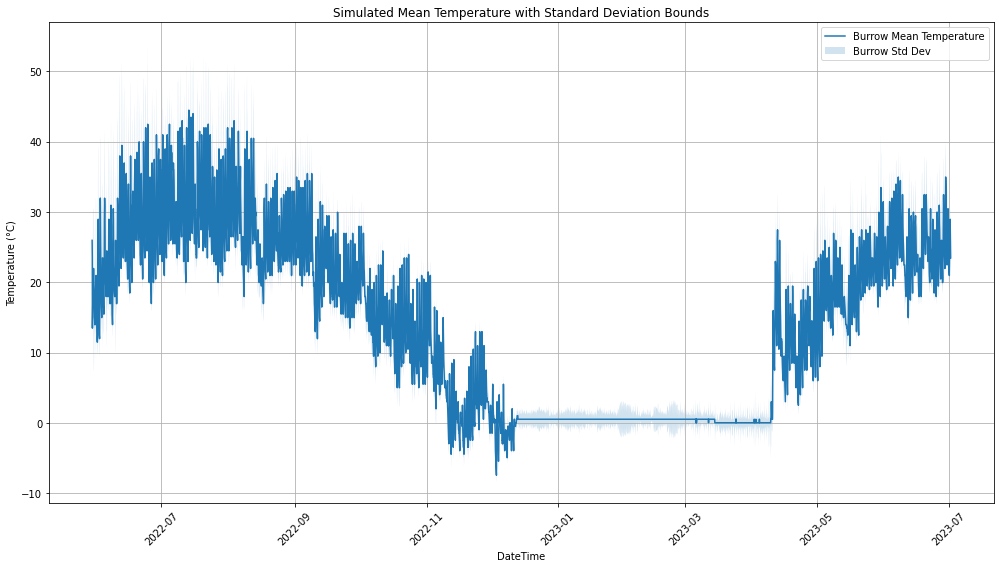

In [73]:
def plot_time_series_with_std(df, mean_col, std_col, label):
    mean = df[mean_col]
    std = df[std_col]
    plt.plot(df['DateTime'], mean, label=f"{label} Mean Temperature")
    plt.fill_between(df['DateTime'], mean - std, mean + std, alpha=0.2, label=f"{label} Std Dev")
    
start_date = '2022-06-01'
end_date = '2022-06-30'

filtered_df = otm_data[(otm_data['Study_Site'] == 'Nebraska')] #& 
#                  (otm_data['DateTime'] >= start_date) & 
#                  (otm_data['DateTime'] <= end_date)]

plt.figure(figsize=(14, 8))

# Plotting the simulated data
#plot_time_series_with_std(filtered_df, 'Open_mean_Temperature', 'Open_stddev_Temperature', 'Open')
plot_time_series_with_std(filtered_df, 'Burrow_mean_Temperature', 'Burrow_stddev_Temperature', 'Burrow')
#plot_time_series_with_std(filtered_df, 'Shrub_mean_Temperature', 'Shrub_stddev_Temperature', 'Shrub')


plt.xlabel('DateTime')
plt.ylabel('Temperature (°C)')
plt.title('Simulated Mean Temperature with Standard Deviation Bounds')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [41]:
filtered_df['Burrow_stddev_Temperature'].quantile(.75)

#0.891
#2.939

2.9393610983794862

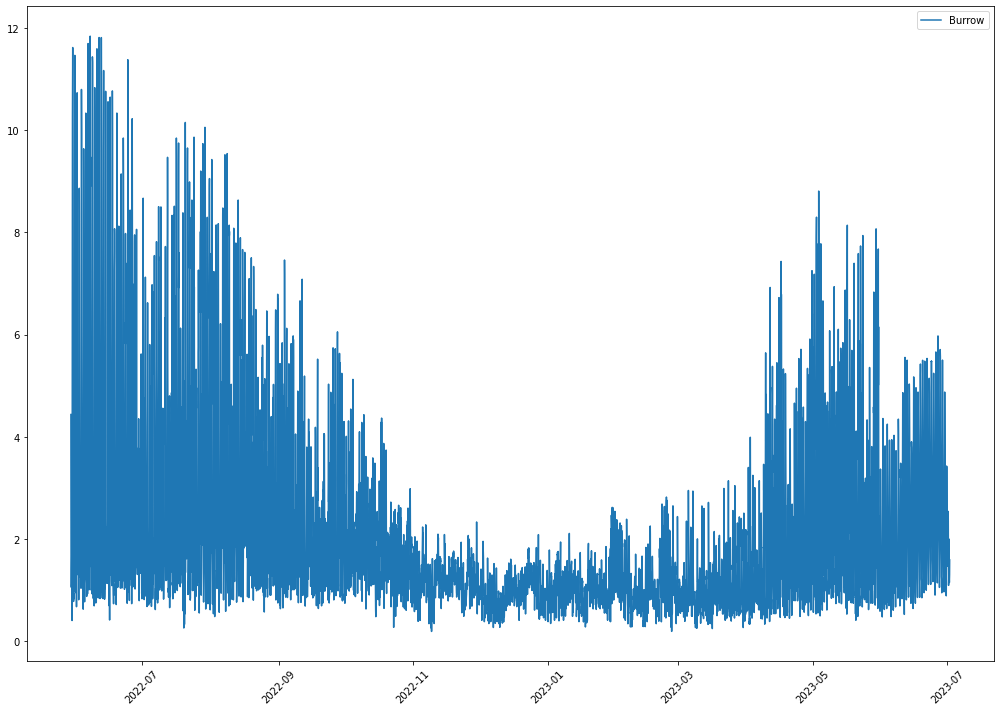

In [74]:
plt.figure(figsize=(14, 10))
#plt.plot(filtered_df['DateTime'], filtered_df['Open_stddev_Temperature'], label='Open')
plt.plot(filtered_df['DateTime'], filtered_df['Burrow_stddev_Temperature'], label='Burrow')
#plt.plot(filtered_df['DateTime'], filtered_df['Shrub_stddev_Temperature'], label='Shrub')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.show()

<Axes: xlabel='DateTime', ylabel='Burrow_stddev_Temperature'>

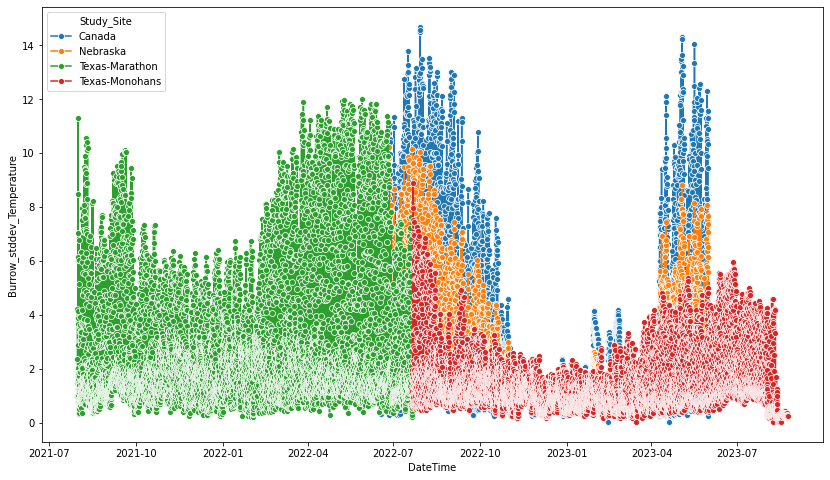

In [75]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=otm_data, x='DateTime', y='Burrow_stddev_Temperature', hue='Study_Site', marker='o')

In [54]:
otm_data.head()

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime
0,2022,6,17,23,Canada,18.48650,1.632718,21.1220,0.004243,21.633000,0.493000,2022-06-17 23:00:00
1,2022,6,18,0,Canada,17.86075,1.034088,18.3690,0.359210,18.963333,1.035800,2022-06-18 00:00:00
2,2022,6,18,1,Canada,17.73575,1.094420,19.1205,0.004950,19.965000,0.570721,2022-06-18 01:00:00
3,2022,6,18,2,Canada,16.85950,0.661747,16.3660,0.359210,17.628000,0.859970,2022-06-18 02:00:00
4,2022,6,18,3,Canada,16.48375,0.499659,15.3645,0.359917,16.458667,0.571007,2022-06-18 03:00:00


In [48]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model to the time series with only one sensor
model = ARIMA(otm_data['Burrow_mean_Temperature'], order=(1, 0, 0))  # AR(1) model
model_fit = model.fit()

# Use the residuals to estimate the standard deviation
estimated_stddev = np.std(model_fit.resid)
print(estimated_stddev)

/home/mremington/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mremington/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/mremington/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1.0958378319057973


In [76]:

otm_data[otm_data['Study_Site'] == 'Nebraska'].head(20)

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime,Mean_StdDev
7152,2022,5,29,20,Nebraska,25.961,4.435334,23.3890,1.032376,22.1160,0.066468,2022-05-29 20:00:00,4.435334
7153,2022,5,29,21,Nebraska,24.461,2.496843,20.8870,1.033790,20.6155,0.065761,2022-05-29 21:00:00,2.496843
7154,2022,5,29,22,Nebraska,23.461,1.404888,19.8860,0.326683,20.1145,0.065761,2022-05-29 22:00:00,1.404888
7155,2022,5,29,23,Nebraska,13.472,1.094737,13.3740,0.376181,13.3530,0.417193,2022-05-29 23:00:00,1.094737
7156,2022,5,30,1,Nebraska,15.968,1.052268,14.3760,0.332340,13.8545,0.417900,2022-05-30 01:00:00,1.052268
7157,2022,5,30,2,Nebraska,16.467,1.118083,14.6260,0.685894,14.3555,0.417900,2022-05-30 02:00:00,1.118083
7158,2022,5,30,3,Nebraska,16.966,1.121328,14.6260,0.685894,14.6060,0.772161,2022-05-30 03:00:00,1.121328
7159,2022,5,30,4,Nebraska,16.966,1.439962,14.3760,0.332340,14.3555,0.417900,2022-05-30 04:00:00,1.439962
7160,2022,5,30,5,Nebraska,16.467,1.723898,14.3760,0.332340,14.3555,0.417900,2022-05-30 05:00:00,1.723898
7161,2022,5,30,6,Nebraska,16.467,1.817992,13.8750,0.332340,14.1050,0.063640,2022-05-30 06:00:00,1.817992


In [30]:
filtered_df.head(50)

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime
7152,2022,5,29,20,Nebraska,25.961,NaN,23.3890,1.032376,22.1160,0.066468,2022-05-29 20:00:00
7153,2022,5,29,21,Nebraska,24.461,NaN,20.8870,1.033790,20.6155,0.065761,2022-05-29 21:00:00
7154,2022,5,29,22,Nebraska,23.461,NaN,19.8860,0.326683,20.1145,0.065761,2022-05-29 22:00:00
7155,2022,5,29,23,Nebraska,13.472,NaN,13.3740,0.376181,13.3530,0.417193,2022-05-29 23:00:00
7156,2022,5,30,1,Nebraska,15.968,NaN,14.3760,0.332340,13.8545,0.417900,2022-05-30 01:00:00
7157,2022,5,30,2,Nebraska,16.467,NaN,14.6260,0.685894,14.3555,0.417900,2022-05-30 02:00:00
7158,2022,5,30,3,Nebraska,16.966,NaN,14.6260,0.685894,14.6060,0.772161,2022-05-30 03:00:00
7159,2022,5,30,4,Nebraska,16.966,NaN,14.3760,0.332340,14.3555,0.417900,2022-05-30 04:00:00
7160,2022,5,30,5,Nebraska,16.467,NaN,14.3760,0.332340,14.3555,0.417900,2022-05-30 05:00:00
7161,2022,5,30,6,Nebraska,16.467,NaN,13.8750,0.332340,14.1050,0.063640,2022-05-30 06:00:00


In [78]:
nan_microhabitat_rows = otm_data[otm_data['Burrow_stddev_Temperature'].isna()]
nan_microhabitat_rows.head()
#plt.plot(otm_data['DateTime'], nan_microhabitat_rows['Burrow_stddev_Temperature'], label='Burrow')

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime,Mean_StdDev
8223,2022,7,20,21,Nebraska,33.466,NaN,24.619667,2.980679,25.947667,0.620669,2022-07-20 21:00:00,NaN


In [79]:
# Drop NA values
otm_data.dropna(inplace=True)

# Sort the DataFrame by Study_Site and DateTime
otm_data.sort_values(by=['Study_Site', 'DateTime'], inplace=True)

# Save each Study_Site to a separate CSV file
study_sites = otm_data['Study_Site'].unique()
for site in study_sites:
    site_data = otm_data[otm_data['Study_Site'] == site]
    site_data.to_csv(f'Data/{site}_data.csv', index=False)